In [ ]:
pip install pydub

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import Audio
from keras import layers
from keras import models
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.python.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
from sklearn.model_selection import KFold
# from pydub import AudioSegment
# from pydub.utils import make_chunks
# import itertools

In [ ]:
from google.colab  import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
Path = "/content/drive/MyDrive/Colab Notebooks/Dataset"

In [ ]:
# data = []
# for wav in os.listdir(Path):
#   emotion = wav.partition(".wav")[0].split('_')
#   if emotion[0] == 'Abuse':
#     data.append(('Abusive', Path+'/'+wav))
#   elif emotion[2] == 'DRU':
#     data.append(('Drunk', Path+'/'+wav))
#   elif emotion[2] == 'DIS':
#     data.append(('Painful', Path+'/'+wav))
#   elif emotion[2] == 'FEA':
#     data.append(('Stressful', Path+'/'+wav))
#   elif emotion[2] == 'HAP':
#     data.append(('Prank', Path+'/'+wav))
#   elif emotion[2] == 'ANG':
#     data.append(('Angry', Path+'/'+wav))
#   elif emotion[2] == 'SAD':
#     data.append(('Sad', Path+'/'+wav))
#   elif emotion[2] == 'NEU':
#     data.append(('Neutral', Path+'/'+wav))
# df = pd.DataFrame.from_dict(data)
# df.rename(columns={0:'Emotion', 1:'Path'}, inplace=True)
# df.head()

data = []
for wav in os.listdir(Path):
  emotion = wav.partition(".wav")[0].split('_')
  if emotion[0] == 'Abuse':
      data.append(('Abusive', Path+'/'+wav))
  if len(emotion) >= 3:
    # if emotion[2] == 'DRU':
    #   data.append(('Drunk', Path+'/'+wav))
    if emotion[2] == 'DIS':
      data.append(('Painful', Path+'/'+wav))
    elif emotion[2] == 'FEA':
      data.append(('Stressful', Path+'/'+wav))
    elif emotion[2] == 'HAP':
      data.append(('Prank', Path+'/'+wav))
    elif emotion[2] == 'ANG':
      data.append(('Angry', Path+'/'+wav))
    elif emotion[2] == 'SAD':
      data.append(('Sad', Path+'/'+wav))
    elif emotion[2] == 'NEU':
      data.append(('Neutral', Path+'/'+wav))
df = pd.DataFrame.from_dict(data)
df.rename(columns={0:'Emotion', 1:'Path'}, inplace=True)
df.head()


,Emotion,Path
0,Abusive,/content/drive/MyDrive/Colab Notebooks/Dataset...
1,Abusive,/content/drive/MyDrive/Colab Notebooks/Dataset...
2,Abusive,/content/drive/MyDrive/Colab Notebooks/Dataset...
3,Abusive,/content/drive/MyDrive/Colab Notebooks/Dataset...
4,Angry,/content/drive/MyDrive/Colab Notebooks/Dataset...


In [ ]:
df

,Emotion,Path
0,Abusive,/content/drive/MyDrive/Colab Notebooks/Dataset...
1,Abusive,/content/drive/MyDrive/Colab Notebooks/Dataset...
2,Abusive,/content/drive/MyDrive/Colab Notebooks/Dataset...
3,Abusive,/content/drive/MyDrive/Colab Notebooks/Dataset...
4,Angry,/content/drive/MyDrive/Colab Notebooks/Dataset...
...,...,...
674,Painful,/content/drive/MyDrive/Colab Notebooks/Dataset...
675,Painful,/content/drive/MyDrive/Colab Notebooks/Dataset...
676,Angry,/content/drive/MyDrive/Colab Notebooks/Dataset...
677,Stressful,/content/drive/MyDrive/Colab Notebooks/Dataset...


In [ ]:
df.shape

(679, 2)

In [ ]:
%matplotlib inline

plt.style.use("ggplot")

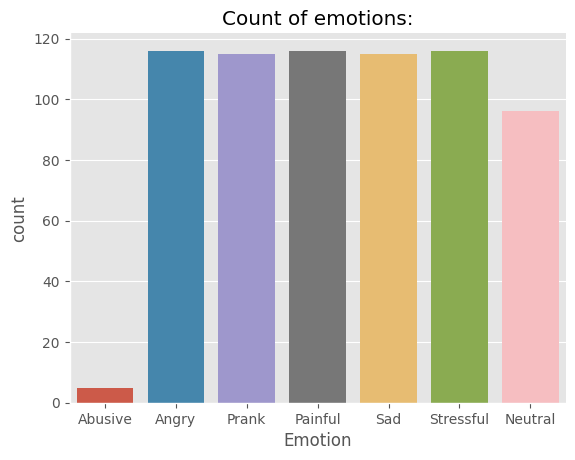

In [ ]:
plt.title("Count of emotions:")
sns.countplot(x=df["Emotion"])
sns.despine(top=True, right=True, left=False, bottom=False)

In [ ]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title(f'Waveplot for audio with {e} emotion', size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=44100, x_axis='time', y_axis='hz')
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

In [ ]:
def noise(data, random=False, rate=0.035, threshold=0.075):
    """Add some noise to sound sample. Use random if you want to add random noise with some threshold.
    Or use rate Random=False and rate for always adding fixed noise."""
    if random:
        rate = np.random.random() * threshold
    noise_amp = rate*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    """Stretching data with some rate."""
    return librosa.effects.time_stretch(data, rate)

def shift(data, rate=1000):
    """Shifting data with some rate"""
    shift_range = int(np.random.uniform(low=-5, high = 5)*rate)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7, random=False):
    """"Add some pitch to sound sample. Use random if you want to add random pitch with some threshold.
    Or use pitch_factor Random=False and rate for always adding fixed pitch."""
    if random:
        pitch_factor=np.random.random() * pitch_factor
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

In [ ]:
n_fft = 2048
hop_length = 512

In [ ]:
def zcr(data, frame_length=2048, hop_length=512):
    zcr = librosa.feature.zero_crossing_rate(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(zcr)

def rmse(data, frame_length=2048, hop_length=512):
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse)

def mfcc(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
    mfcc_feature = librosa.feature.mfcc(y=data, sr=sr)
    return np.squeeze(mfcc_feature.T) if not flatten else np.ravel(mfcc_feature.T)

In [ ]:
path = np.array(df["Path"])[10]
data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
len(data)

30915

In [ ]:
def extract_features(data, sr, frame_length=2048, hop_length=512):
    result = np.array([])
    result = np.hstack((result,
                        zcr(data, frame_length, hop_length),
                        rmse(data, frame_length, hop_length),
                        mfcc(data, sr, frame_length, hop_length)
                                    ))
    return result

In [ ]:
def get_features(path, duration=2.5, offset=0.6):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=duration, offset=offset)

     # without augmentation
    res1 = extract_features(data, sample_rate)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data, random=True)
    res2 = extract_features(noise_data, sample_rate)
    result = np.vstack((result, res2)) # stacking vertically

    # data with pitching
    pitched_data = pitch(data, sample_rate, random=True)
    res3 = extract_features(pitched_data, sample_rate)
    result = np.vstack((result, res3)) # stacking vertically

    # data with pitching and white_noise
    new_data = pitch(data, sample_rate, random=True)
    data_noise_pitch = noise(new_data, random=True)
    res3 = extract_features(data_noise_pitch, sample_rate)
    result = np.vstack((result, res3)) # stacking vertically

    return result

In [ ]:
X, Y = [], []
print("Feature processing...")
for path, emotion, ind in zip(df.Path, df.Emotion, range(df.Path.shape[0])):
    features = get_features(path)
    if ind % 100 == 0:
        print(f"{ind} samples has been processed...")
    for ele in features:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)
print("Done.")

Feature processing...


TypeError: ignored

In [ ]:
features_path = "./features.csv"

In [ ]:
extracted_df = pd.DataFrame(X)
extracted_df["labels"] = Y
extracted_df.to_csv(features_path, index=False)
extracted_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,labels
0,0.027344,0.057617,0.104004,0.136230,0.136230,0.129883,0.100586,0.070801,0.069336,0.074219,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Angry
1,0.125000,0.224609,0.327637,0.359863,0.306152,0.236328,0.160156,0.126465,0.159180,0.168945,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Angry
2,0.027832,0.067383,0.103516,0.121094,0.125000,0.108887,0.087402,0.069824,0.074219,0.080078,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Angry
3,0.032715,0.084473,0.125000,0.141602,0.142090,0.114746,0.087402,0.067871,0.074219,0.079590,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Angry
4,0.041504,0.059082,0.070312,0.061035,0.072754,0.118164,0.134766,0.137695,0.123047,0.072266,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Painful


In [ ]:
extracted_df = pd.read_csv(features_path)
print(extracted_df.shape)

(34264, 2377)


In [ ]:
# Fill NaN with 0
extracted_df = extracted_df.fillna(0)
print(extracted_df.isna().any())
extracted_df.shape

0         False
1         False
2         False
3         False
4         False
          ...  
2372      False
2373      False
2374      False
2375      False
labels    False
Length: 2377, dtype: bool


(34264, 2377)

In [ ]:
extracted_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,labels
0,0.027344,0.057617,0.104004,0.136230,0.136230,0.129883,0.100586,0.070801,0.069336,0.074219,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Angry
1,0.125000,0.224609,0.327637,0.359863,0.306152,0.236328,0.160156,0.126465,0.159180,0.168945,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Angry
2,0.027832,0.067383,0.103516,0.121094,0.125000,0.108887,0.087402,0.069824,0.074219,0.080078,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Angry
3,0.032715,0.084473,0.125000,0.141602,0.142090,0.114746,0.087402,0.067871,0.074219,0.079590,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Angry
4,0.041504,0.059082,0.070312,0.061035,0.072754,0.118164,0.134766,0.137695,0.123047,0.072266,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Painful


In [ ]:
X = extracted_df.drop(labels="labels", axis=1)
Y = extracted_df["labels"]

In [ ]:
lb = LabelEncoder()
Y = np_utils.to_categorical(lb.fit_transform(Y))
print(lb.classes_)
Y

['Abusive' 'Angry' 'Neutral' 'Painful' 'Prank' 'Sad' 'Stressful']


array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
# # Not using
# kf = KFold(n_splits=5, random_state = 1, shuffle=True)
# for train, test in kf.split(X):
#   print("%s %s" % (train, test))

In [ ]:
# # Not using
# X1=np.array(X)
# X1_train=X1[train]
# X1_test=X1[test]
# Y1=np.array(Y)
# Y1_train=Y1[train]
# Y1_test=Y1[test]

In [ ]:
# # Not using
# # Standardize data
# scaler = StandardScaler()
# X1_train = scaler.fit_transform(X1_train)
# X1_test = scaler.transform(X1_test)
# X1_train.shape, X1_test.shape, Y1_train.shape, Y1_test.shape

In [ ]:
# # Not using
# # We have to use 1-dimensional CNN which need specifical shape:
# X1_train = np.expand_dims(X1_train, axis=2)
# X1_test = np.expand_dims(X1_test, axis=2)
# X1_train.shape

In [ ]:
# # Not using
# earlystopping = EarlyStopping(monitor ="val_acc",
#                               mode = 'auto', patience = 5,
#                               restore_best_weights = True)

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=2,
                                            verbose=1,
                                            factor=0.2)

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
# model = models.Sequential()
# model.add(layers.Conv1D(256, kernel_size=5, strides=1,
#                         padding="same", activation="relu",
#                         input_shape=(X1_train.shape[1], 1)))
# model.add(layers.BatchNormalization())
# model.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))

# model.add(layers.Conv1D(256, kernel_size=5, strides=1,
#                         padding="same", activation="relu"))
# model.add(layers.BatchNormalization())
# model.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))

# model.add(layers.Conv1D(128, kernel_size=5, strides=1,
#                         padding="same", activation="relu"))
# model.add(layers.BatchNormalization())
# model.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))

# model.add(layers.Conv1D(256, kernel_size=3, strides=1, padding='same', activation='relu'))
# model.add(layers.BatchNormalization())
# model.add(layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

# model.add(layers.Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu'))
# model.add(layers.BatchNormalization())
# model.add(layers.MaxPooling1D(pool_size=3, strides = 2, padding = 'same'))

# model.add(layers.Flatten())
# model.add(layers.Dense(128, activation='relu'))
# model.add(layers.BatchNormalization())
# model.add(layers.Dense(8, activation="softmax"))

# model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["acc", f1_m])





# model = models.Sequential()
# model.add(layers.Conv1D(64, kernel_size=5, strides=1,
#                         padding="same", activation="relu",
#                         input_shape=(X1_train.shape[1], 1)))
# model.add(layers.BatchNormalization())
# model.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))
# model.add(layers.Dropout(0.2))

# model.add(layers.Conv1D(128, kernel_size=5, strides=1,
#                         padding="valid", activation="relu"))
# model.add(layers.BatchNormalization())
# model.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))
# model.add(layers.Dropout(0.2))

# model.add(layers.Conv1D(256, kernel_size=3, strides=1, padding='valid', activation='relu'))
# model.add(layers.BatchNormalization())
# model.add(layers.MaxPooling1D(pool_size=3, strides = 2, padding = 'same'))
# model.add(layers.Dropout(0.2))

# model.add(layers.Conv1D(512, kernel_size=3, strides=1, padding='valid', activation='relu'))
# model.add(layers.BatchNormalization())
# model.add(layers.MaxPooling1D(pool_size=3, strides = 2, padding = 'same'))
# model.add(layers.Dropout(0.2))

# model.add(layers.Flatten())
# model.add(layers.Dense(512, activation='relu'))
# model.add(layers.BatchNormalization())
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(7, activation="softmax"))

# model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["acc", f1_m])





# from tensorflow.keras import layers, models

model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(X_train.shape[0], X_train.shape[1], 1)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((3, 3), padding="same"))
model.add(layers.Dropout(0.5))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((3, 3), padding="same"))
model.add(layers.Dropout(0.5))

model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((3, 3), padding="same"))
model.add(layers.Dropout(0.5))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(7, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



NameError: name 'models' is not defined

In [ ]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 38, 214, 64)       640       
                                                                 
 batch_normalization_18 (Bat  (None, 38, 214, 64)      256       
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 13, 72, 64)       0         
 2D)                                                             
                                                                 
 dropout_14 (Dropout)        (None, 13, 72, 64)        0         
                                                                 
 conv2d_20 (Conv2D)          (None, 11, 70, 128)       73856     
                                                                 
 batch_normalization_19 (Bat  (None, 11, 70, 128)    

In [ ]:
EPOCHS = 20
batch_size = 64

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], 40, 216, 1))
X_val = np.reshape(X_val, (X_val.shape[0], 40, 216, 1))
X_test = np.reshape(X_test, (X_test.shape[0], 40, 216, 1))

ValueError: cannot reshape array of size 65130912 into shape (27412,40,216,1)

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=EPOCHS, batch_size=batch_size, callbacks=[learning_rate_reduction])

Epoch 1/20


ValueError: in user code:

    File "c:\Users\User\anaconda3\lib\site-packages\keras\engine\training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\User\anaconda3\lib\site-packages\keras\engine\training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\User\anaconda3\lib\site-packages\keras\engine\training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\User\anaconda3\lib\site-packages\keras\engine\training.py", line 889, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\User\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\User\anaconda3\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential_17" is incompatible with the layer: expected shape=(None, 40, 216, 1), found shape=(None, 2376)


130/130 [==============================] - 4s 27ms/step - loss: 0.1123 - acc: 0.9680 - f1_m: 0.9689
Accuracy of our model on test data :  96.80387377738953 %


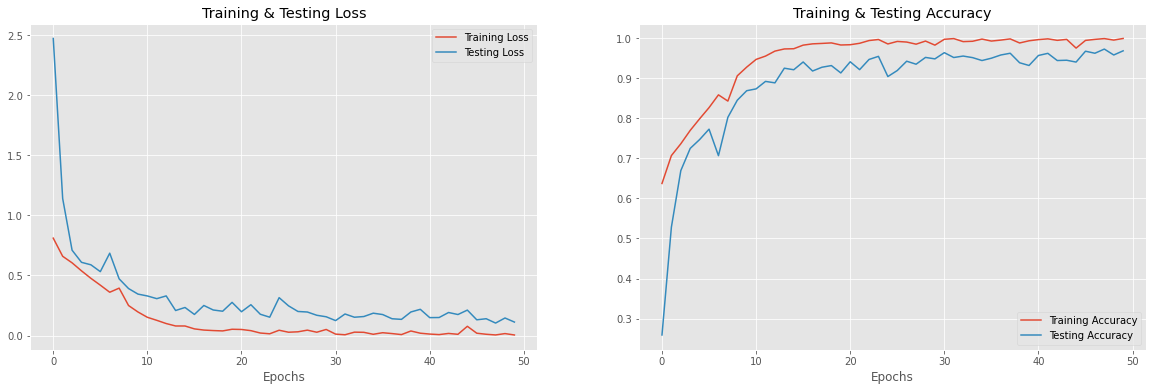

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(X1_test,Y1_test)[1]*100 , "%")

fig , ax = plt.subplots(1,2)
train_acc = history.history['acc']
train_loss = history.history['loss']
test_acc = history.history['val_acc']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(train_loss, label = 'Training Loss')
ax[0].plot(test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(train_acc, label = 'Training Accuracy')
ax[1].plot(test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
y_pred = model.predict(X1_test)
y_pred = np.argmax(y_pred, axis=1)
y_pred

array([2, 2, 4, ..., 0, 0, 0])

In [ ]:
y_check = np.argmax(Y1_test, axis=1)
y_check

array([2, 2, 4, ..., 0, 0, 0])

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true=y_check, y_pred=y_pred)

In [ ]:
import itertools
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[921   0   3   1   0]
 [  6 159   0   0   0]
 [  0   1 975  22  16]
 [  0   1   9 981  13]
 [  1   0  28  31 962]]


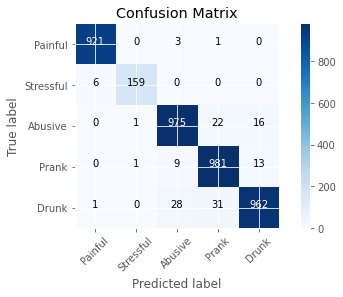

In [ ]:
cm_plot_labels = ['Painful', 'Stressful', 'Abusive', 'Prank', 'Drunk']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [ ]:
path_to_model = "./res_model.h5"

model.save(path_to_model)


In [ ]:
# Save the weights
model.save_weights('./checkpoints/my_checkpoint')

# Create a new model instance
'''model = create_model()

# Restore the weights
model.load_weights('./checkpoints/my_checkpoint')'''

# Evaluate the model
#loss, acc = model.evaluate(X_test[1], X_test[0] , verbose=2)
#print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

"model = create_model()\n\n# Restore the weights\nmodel.load_weights('./checkpoints/my_checkpoint')"

In [ ]:
# Create and train a new model instance.
#model = create_model()
model.fit(X1_train, Y1_train, epochs=5)

# Save the entire model as a SavedModel.
!mkdir -p saved_model
model.save('saved_model/my_model')
new_model = tf.keras.models.load_model('saved_model/my_model')